In [1]:
from datetime import datetime
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import Bounds, minimize

from environments import ARESEAOptimization, ResetActuatorsToDFD

In [2]:
def pack_dataframe(fn):
    def wrapper(env, problem=None):
        observations, beam_images = fn(env, problem=problem)
        observations = np.array(observations)

        df = pd.DataFrame(np.arange(len(observations)), columns=["step"])
        df["q1"] = observations[:,0]
        df["q2"] = observations[:,1]
        df["q3"] = observations[:,2]
        df["cv"] = observations[:,3]
        df["ch"] = observations[:,4]
        df["mup_x"] = observations[:,5]
        df["mup_y"] = observations[:,6]
        df["sigmap_x"] = observations[:,7]
        df["sigmap_y"] = observations[:,8]
        df["mu_x"] = observations[:,9]
        df["mu_y"] = observations[:,10]
        df["sigma_x"] = observations[:,11]
        df["sigma_y"] = observations[:,12]
        df["beam_image"] = beam_images

        df["measure_beam"] = env.backend._beam_parameter_method

        return df
    
    return wrapper

In [3]:
@pack_dataframe
def run(env, problem=None):
    if problem is not None:
        if "initial" in problem:
            env.unwrapped.next_initial = problem["initial"]
        if "desired" in problem:
            env.unwrapped.next_desired = problem["desired"]

    observations = []
    beam_images = []

    observation = env.reset()

    observations.append(observation)
    beam_images.append(env.unwrapped.backend.last_beam_image)

    env.unwrapped.next_initial = "stay"

    def optfn(actuators):
        observation, objective, _, _ = env.step(actuators)
        observations.append(observation)
        beam_images.append(env.unwrapped.backend.last_beam_image)
        return objective

    bounds = Bounds(env.action_space.low, env.action_space.high)
    res = minimize(optfn, observation[:5], method="Nelder-Mead", bounds=bounds, options={"fatol": 4.5e-11, "xatol": 1, "maxfev": 300, "disp":True})

    observation, _, _, _ = env.step(res.x)
    observations.append(observation)
    beam_images.append(env.unwrapped.backend.last_beam_image)

    return observations, beam_images

In [4]:
env = ARESEAOptimization(backend="machine", objective="mse", backendargs={"measure_beam": "us"})
env = ResetActuatorsToDFD(env)

In [5]:
with open("problems_3.json", "r") as f:
    problems = json.load(f)

In [6]:
run_name = "test_nelder_mead_dfd_300"
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

df = run(env, problems[0])

df.to_pickle(f"machine_studies/opt_nelder_{timestamp}_{run_name}.pkl")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 98
         Function evaluations: 168


## Evaluation Stuff

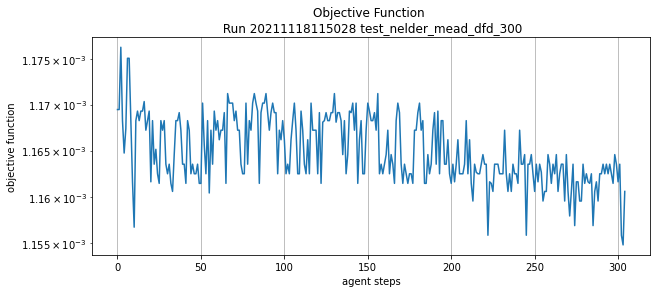

In [9]:
# Compute MAE
df["delta_mu_x"] = np.abs(df["mup_x"] - df["mu_x"])
df["delta_mu_y"] = np.abs(df["mup_x"] - df["mu_x"])
df["delta_sigma_x"] = np.abs(df["sigmap_x"] - df["sigma_x"])
df["delta_sigma_y"] = np.abs(df["sigmap_y"] - df["sigma_y"])
df["mae"] = (df["delta_mu_x"] + df["delta_mu_y"] + df["delta_sigma_x"] + df["delta_sigma_y"]) / 4

plt.figure(figsize=(10,4))
plt.plot(df["mae"])
plt.title(f'Objective Function \n Run {timestamp} {run_name}')
plt.xlabel('agent steps')
plt.ylabel('objective function')
plt.grid(True)

plt.savefig(f'machine_studies/plots/{timestamp}_{run_name}_objective_plot.pdf',bbox_inches = 'tight')
plt.savefig(f'machine_studies/plots/{timestamp}_{run_name}_objective_plot.png',bbox_inches = 'tight')

plt.yscale('log')

plt.savefig(f'machine_studies/plots/{timestamp}_{run_name}_objective_plot_ylog.pdf',bbox_inches = 'tight')
plt.savefig(f'machine_studies/plots/{timestamp}_{run_name}_objective_plot_ylog.png',bbox_inches = 'tight')

plt.show()
